In [ ]:
# Instalacion de dependencias
!pip install pyspark

In [1]:
# Importacion de dependencias
from pyspark.ml.feature import Tokenizer
from pyspark.sql import SparkSession
from pyspark.ml.feature import StopWordsRemover
from pyspark.sql.functions import udf
from pyspark.sql.types import IntegerType
from pyspark.sql.types import ArrayType
from pyspark.sql.types import StringType
from pyspark.sql.functions import *
import re
import nltk
from nltk.stem import LancasterStemmer
from nltk.stem import WordNetLemmatizer
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Creacion del Spark Session
spark = SparkSession.builder.appName('TokenizacionSpark').getOrCreate()
sc = spark.sparkContext

In [3]:
# Punto 1
## Se busca construir el BoW mas optimizado del archivo solicitado
## Eliminando stop words, tokenizando, haciendo stemming y lemmatizacion

# Lectura del archivo
file = spark.read.text('./data/0704.3504.pdf.txt')

In [4]:
# Tokenizacion
tokenization = Tokenizer(inputCol='value', outputCol='tokens')

file = file.select(trim(col('value')).alias('value'))

tokens = tokenization.transform(file)

In [5]:
# Eliminacion de caracteres no alfabeticos
def noAlphaRemove_udf(x):
    newTokens = [re.sub(r'[^A-Za-z]+','',w) for w in x]
    newTokens = [w.lower() for w in newTokens if len(w) > 1]
    return newTokens
noAlphaRemove = udf(lambda s: noAlphaRemove_udf(s), ArrayType(StringType()))

tokens = tokens.withColumn('Clean',noAlphaRemove(col('tokens')))

In [6]:
# Remocion de stopwords
stopWordRemover=StopWordsRemover(inputCol='Clean',outputCol='StopWordsClean')
tokens = stopWordRemover.transform(tokens)

In [7]:
# Stemming
stemmer = LancasterStemmer()
def stemming_udf(x):
    newTokens = [stemmer.stem(w) for w in x]
    return newTokens
stemmingFunction = udf(lambda s: stemming_udf(s), ArrayType(StringType()))

tokens = tokens.withColumn('Stemming', stemmingFunction(col('StopWordsClean')))

In [8]:
# Lematizacion
lematizer = WordNetLemmatizer()
def lematizer_udf(x):
    newTokens = [lematizer.lemmatize(w) for w in x]
    return newTokens
lematizerFunction = udf(lambda s: lematizer_udf(s), ArrayType(StringType()))

tokens = tokens.withColumn('Lematizacion', lematizerFunction(col('Stemming')))

Numero de tokens: 1681
Longitud del BoW: 397


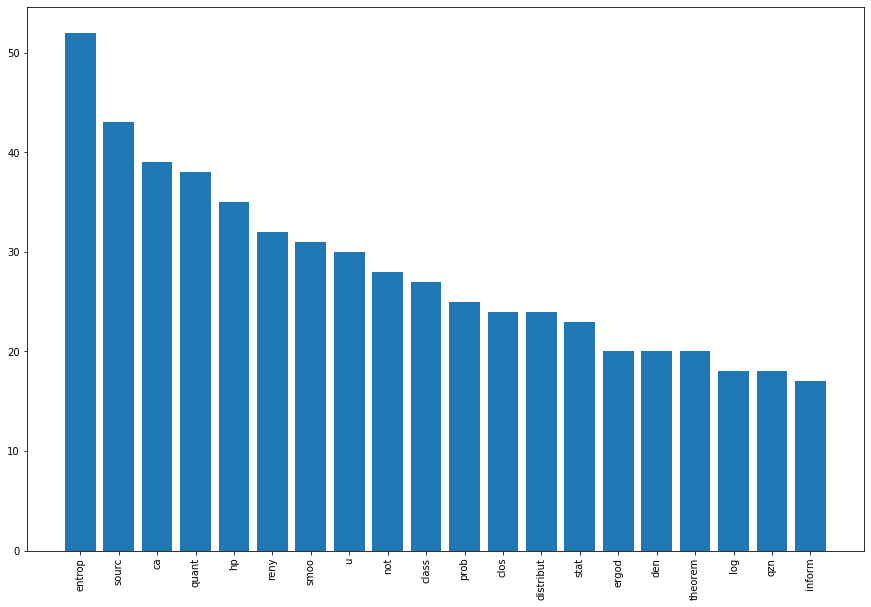

In [10]:
# Distribution
tokens = tokens.withColumn('token_count', size(col('Lematizacion')))
numeroTokens = tokens.select(sum(col('token_count'))).collect()[0][0]
listadoTokens = tokens.agg(concat(collect_list(col('Lematizacion')))).collect()[0][0]
listadoTokens = np.hstack(listadoTokens)

fdist = nltk.FreqDist(listadoTokens)
topWords = fdist.most_common(20)

# Longitud de version final de tokens y BoW luego de lematizacion
print('Numero de tokens: ' + str(numeroTokens))
print('Longitud del BoW: ' +  str(len(fdist)))

# Se muestra el top 20 de palabras
x,y = zip(*topWords)
plt.figure(figsize=(15,10))
plt.bar(x,y)
plt.xticks(rotation=90)
plt.show()
